Formatted Date
2005-12-01 00:00:00+00:00     0.577778
2006-01-01 00:00:00+00:00    -1.677942
2006-02-01 00:00:00+00:00    -0.065394
2006-03-01 00:00:00+00:00     4.559274
2006-04-01 00:00:00+00:00    12.635031
Freq: MS, Name: Temperature (C), dtype: float64


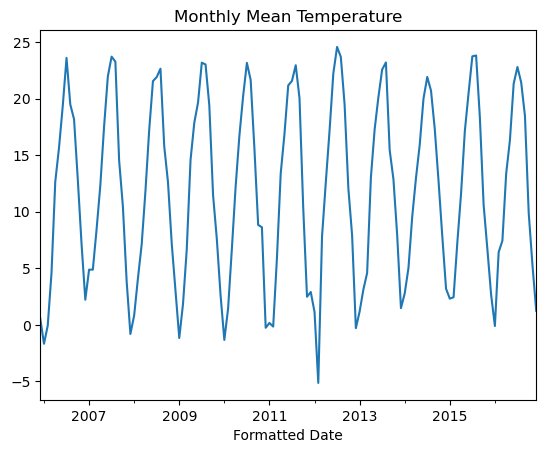

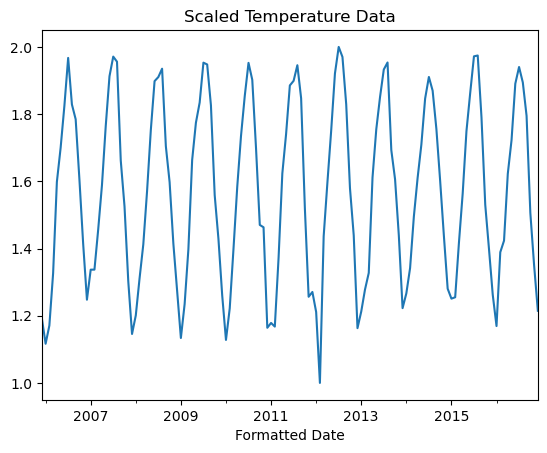

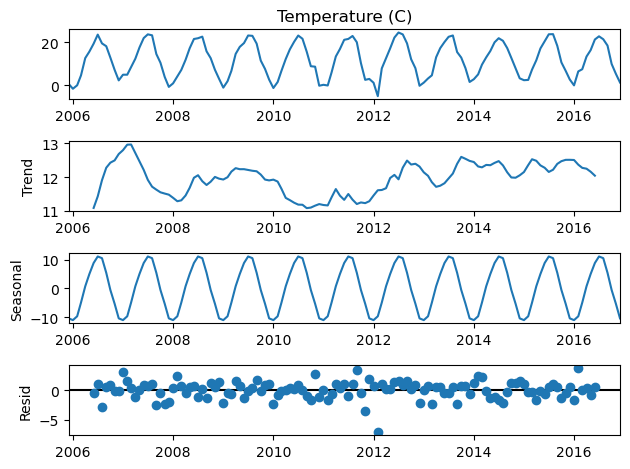

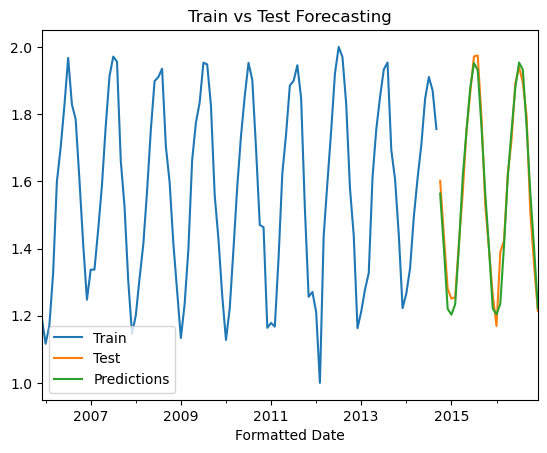

RMSE: 0.04412056608942702
MAE: 0.033206590845432114


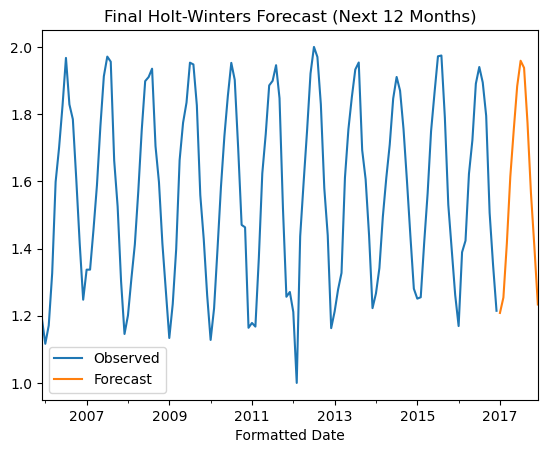

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose

# -----------------------------
# Load dataset
# -----------------------------
data = pd.read_csv("weatherHistory.csv")

# Parse datetime column properly
data['Formatted Date'] = pd.to_datetime(data['Formatted Date'], utc=True, errors='coerce')

# Set as index
data = data.set_index('Formatted Date')

# -----------------------------
# Resample to monthly mean temperature
# -----------------------------
data_monthly = data['Temperature (C)'].resample('MS').mean()
print(data_monthly.head())

# -----------------------------
# Plot raw data
# -----------------------------
data_monthly.plot(title="Monthly Mean Temperature")
plt.show()

# -----------------------------
# Scale data
# -----------------------------
scaler = MinMaxScaler()
scaled_data = pd.Series(
    scaler.fit_transform(data_monthly.values.reshape(-1, 1)).flatten(),
    index=data_monthly.index
)

scaled_data = scaled_data + 1   # ensure positive values

scaled_data.plot(title="Scaled Temperature Data")
plt.show()

# -----------------------------
# Seasonal decomposition
# -----------------------------
decomposition = seasonal_decompose(data_monthly, model="additive", period=12)
decomposition.plot()
plt.show()

# -----------------------------
# Train-test split
# -----------------------------
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

# -----------------------------
# Holt-Winters Model
# -----------------------------
model_add = ExponentialSmoothing(train_data, trend='add', seasonal='mul', seasonal_periods=12).fit()
test_predictions = model_add.forecast(steps=len(test_data))

# Visual evaluation
ax = train_data.plot(label="Train")
test_data.plot(ax=ax, label="Test")
test_predictions.plot(ax=ax, label="Predictions")
ax.legend()
ax.set_title("Train vs Test Forecasting")
plt.show()

# -----------------------------
# Error metrics
# -----------------------------
rmse = np.sqrt(mean_squared_error(test_data, test_predictions))
mae = mean_absolute_error(test_data, test_predictions)
print("RMSE:", rmse)
print("MAE:", mae)

# -----------------------------
# Final model (on full dataset)
# -----------------------------
final_model = ExponentialSmoothing(
    scaled_data, trend='add', seasonal='mul', seasonal_periods=12
).fit()

# Forecast next 12 months
final_predictions = final_model.forecast(steps=12)

# Plot final forecast
ax = scaled_data.plot(label="Observed")
final_predictions.plot(ax=ax, label="Forecast")
ax.legend()
ax.set_title("Final Holt-Winters Forecast (Next 12 Months)")
plt.show()
